# Clustering

Try to cluster the data. See if that makes any sense

In [164]:
.libPaths("~/R/x86_64-redhat-linux-gnu-library/3.2/")
# config opts and libraries
options(repr.plot.width = 6)
options(repr.plot.height = 5)
library(ggplot2);
library(plyr);
library(dplyr);
library(reshape2);
library(LSD);
library(pheatmap);
library(parallel);
options(mc.cores = 24);
library(stringr);
library(RColorBrewer);
library(kernlab);
# load parental data
endo_f = "/g/steinmetz/project/GenPhen/data/endometabolome/data/endometabolite_full_12102015.rda"
load(endo_f)

# set random seed
set.seed(1984);

gg_color_hue <- function(n) {
  hues = seq(15, 375, length=n+1)
  hcl(h=hues, l=65, c=100)[1:n]
}

In [139]:
# only use absolute time for this analysis
endometabolite = endometabolite %>% filter(time_format=="absolute")

In [140]:
head(endometabolite)

,strain,metabolite,replicate,time_format,time,value,value.log2,relative.log2,derivative.log2,cellconc,biovol,singlecellvol,peakarea,batch,cluster
1,01B,AKG,1,absolute,16,NA,NA,NA,NA,5684000,0.4440871,78.12934,9410409,dM1,Y-like
2,01B,AKG,1,absolute,17,64.62115,6.036089,1,NA,11097400,0.7791921,70.21393,10713460,dM1,Y-like
3,01B,AKG,1,absolute,18,75.42941,6.256056,1.036442,0.219967,20590000,1.236393,60.04824,7190772,dM1,Y-like
4,01B,AKG,1,absolute,19,46.9538,5.583573,0.9250316,-0.6724827,29492000,1.918063,65.03671,8510180,dM1,Y-like
5,01B,AKG,1,absolute,20,57.4146,5.868257,0.9721952,0.2846837,47580000,2.669197,56.09914,NA,dM1,Y-like
6,01B,AKG,2,absolute,16,NA,NA,NA,NA,6586800,0.5125937,77.82135,9524785,dM1,Y-like


In [5]:
head(parents)

,strain,parent,time,metabolite,endo_quant,endo_quant_log,exo_quant,exo_quant_log,cellconc_1.ml,biovolume_ul.ml,singlecellvol_fl,endo_quant_log_normalized,exo_quant_log_normalized,endo_quant_rel,exo_quant_rel,endo_rate,exo_rate
1,S1,S288c,16,CIT,3844.5,11.90858,142.43,7.154109,13763600,0.794721,57.74,12.2062,7.049826,1,1,NA,NA
2,S1,S288c,17,CIT,2575.07,11.3304,144.88,7.178715,20412000,1.128718,55.3,11.69755,7.075077,0.9583284,1.003582,-0.5086517,0.02525106
3,S1,S288c,18,CIT,2579.87,11.33308,139.83,7.12753,33698000,1.680631,49.87,11.521,6.951486,0.9438643,0.9860507,-0.1765525,-0.123591
4,S1,S288c,19,CIT,2153.68,11.07259,151.57,7.24384,47319300,2.299066,48.59,11.28718,7.156562,0.9247086,1.01514,-0.2338181,0.2050763
5,S1,S288c,20,CIT,1609.98,10.65283,142.05,7.150255,72192000,3.173397,43.96,10.84166,7.475629,0.8882089,1.060399,-0.4455226,0.3190664
6,S2,S288c,16,CIT,3584.21,11.80744,143.05,7.160376,13303800,0.7479802,56.22,11.88108,7.04624,1,1,NA,NA


In [40]:
#calculate mean growth profile for parentals
mean_growth = parents %>% group_by(parent, time) %>% do({
    thisparent = unique(.$parent)
    value = mean(unique(.$cellconc_1.ml), na.rm = T)
    return(data.frame(cellconc = value))
})
mean_growth$time = as.numeric(levels(mean_growth$time)[mean_growth$time])

In [41]:
seg_growth = endometabolite %>% group_by(strain, time) %>% do({
    thisdf = select(., strain, time, cellconc)
    thisdf = thisdf[!duplicated(thisdf), ]
    thisdf = thisdf %>% group_by(time) %>% summarise(cellconc = mean(cellconc,na.rm=T))
    return(data.frame(thisdf))
})

In [42]:
p <- ggplot(mean_growth, aes(x = time, y = cellconc, group = parent)) +
    geom_line(aes(color = parent))

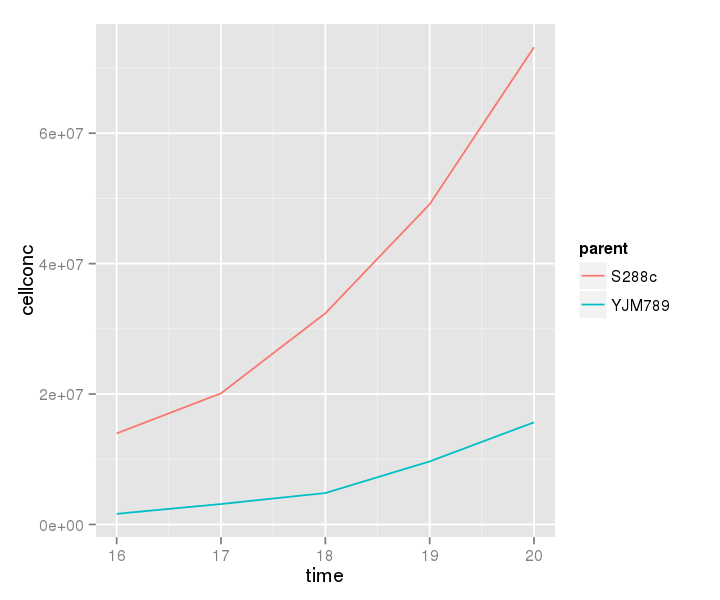

In [43]:
p

Are some strains growth more correlated with one parent or the other?

In [44]:
s = mean_growth %>% filter(parent == "S288c")
y = mean_growth %>% filter(parent == "YJM789")
strain_gcor = endometabolite %>% group_by(strain) %>% do({
    thisdf = select(., strain, time, cellconc)
    thisdf = thisdf[!duplicated(thisdf), ]
    thisdf = thisdf %>% group_by(time) %>% summarise(cellconc = mean(cellconc,na.rm=T))
    stmp = merge(s,thisdf,by = "time")
    ytmp = merge(y,thisdf,by = "time")
    s_sse = sum((stmp$cellconc.x - stmp$cellconc.y)^2, na.rm=T)
    y_sse = sum((ytmp$cellconc.x - ytmp$cellconc.y)^2, na.rm=T)
    return(data.frame(s_sse,y_sse))
})

The upper curve on this plot is weird. As these strains get less similar to Y they also get less similar to X. What is going on here?

Plot growth curves for top 5

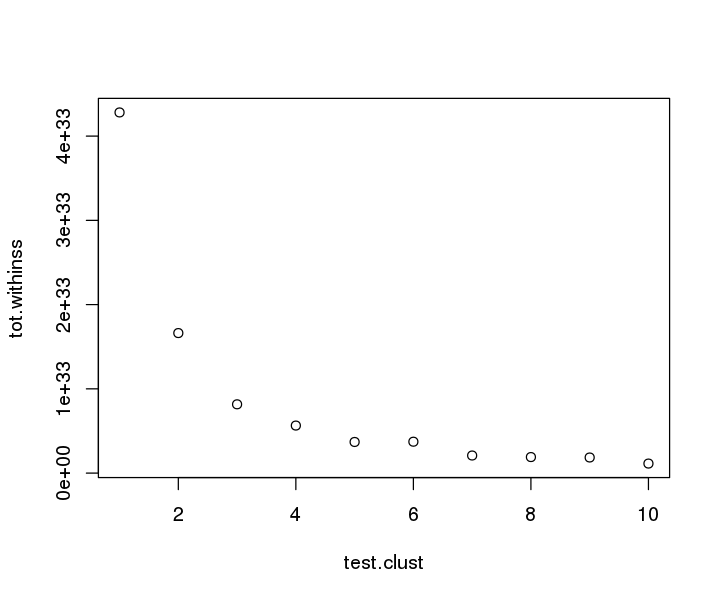

In [90]:
# choose number clusters
tot.withinss = c()
test.clust = seq(1,10)
for (i in test.clust) {
    tmp_clusters = kmeans(as.matrix(strain_gcor[,c("s_sse","y_sse")]), centers=i)
    tot.withinss[i] = tmp_clusters$tot.withinss
}
plot(test.clust, tot.withinss)

In [127]:
# use spectral clustering
#strain_clusters = specc(as.matrix(strain_gcor[,c("s_sse","y_sse")]), centers=3, kernel = "vanilladot")
#strain_gcor$cluster = as.numeric(strain_clusters)

# use kmeans
strain_clusters = kmeans(as.matrix(strain_gcor[,c("s_sse","y_sse")]), centers=3)
clusts = strain_clusters$cluster; names(clusts) = strain_gcor$strain
clusts[clusts == which(strain_clusters$centers[,"y_sse"] == max(strain_clusters$centers[,"y_sse"]))] = "Oddballs"
clusts[clusts == which(strain_clusters$centers[,"y_sse"] == min(strain_clusters$centers[,"y_sse"]))] = "Y-like"
clusts[clusts == which(strain_clusters$centers[,"s_sse"] == min(strain_clusters$centers[,"s_sse"]))] = "S-like"
strain_gcor$cluster = clusts[strain_gcor$strain]

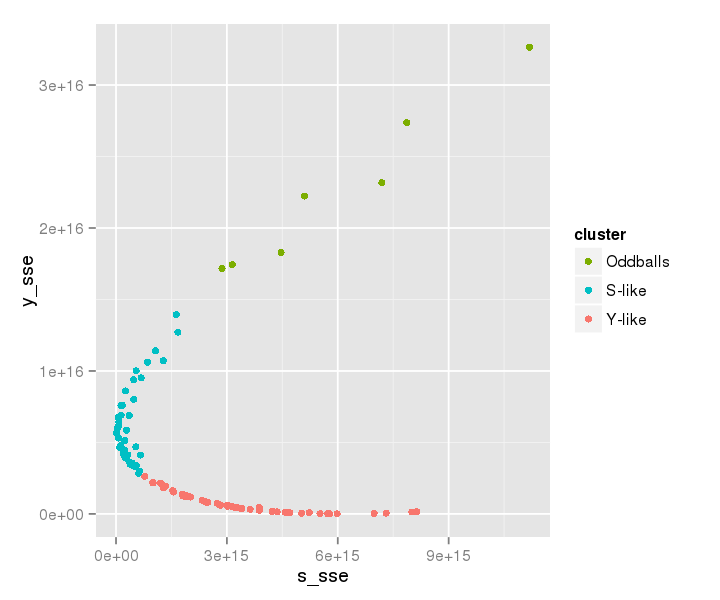

In [128]:
p1 <- ggplot(strain_gcor, aes(x = s_sse, y = y_sse)) +
    geom_point(aes(color = cluster)) + scale_color_manual(values = c(gg_color_hue(4)[c(2,3,1)]))
p1

In [129]:
seg_growth$cluster = clusts[seg_growth$strain]

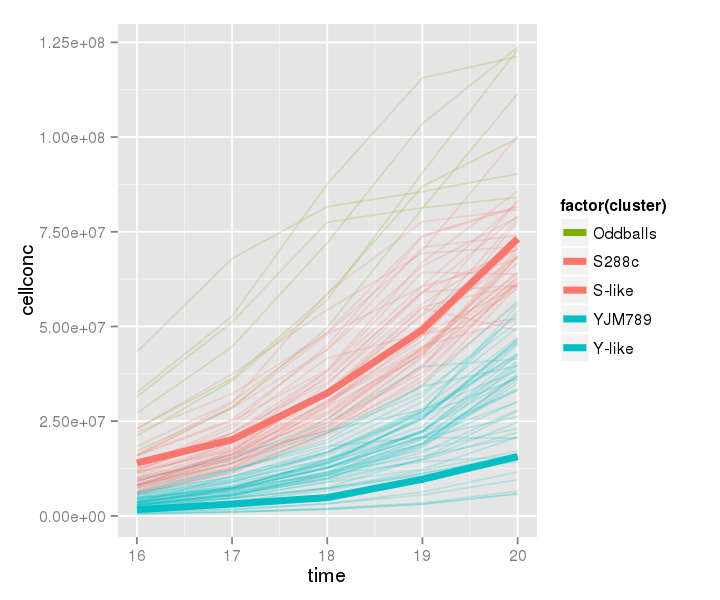

In [130]:
p <- ggplot(seg_growth, aes(x = time, y = cellconc, group = strain)) +
    geom_line(aes(color = factor(cluster)), alpha = 0.2)

p + geom_line(data = mean_growth, aes(x = as.numeric(time), y = cellconc, group = parent, color = parent), lwd = 2) + 
    scale_color_manual(values = c(gg_color_hue(4),gg_color_hue(2))[c(c(2,1,1,3,3))])


In [166]:
endometabolite$cluster = clusts[endometabolite$strain]

In [167]:
head(endometabolite)

,strain,metabolite,replicate,time_format,time,value,value.log2,relative.log2,derivative.log2,cellconc,biovol,singlecellvol,peakarea,batch,cluster
1,01B,AKG,1,relative,1,64.62115,6.036089,1,NA,NA,NA,NA,NA,dM1,Y-like
2,01B,AKG,1,relative,2,75.42941,6.256056,1.036442,0.219967,NA,NA,NA,NA,dM1,Y-like
3,01B,AKG,1,relative,3,46.9538,5.583573,0.9250316,-0.6724827,NA,NA,NA,NA,dM1,Y-like
4,01B,AKG,1,relative,4,57.4146,5.868257,0.9721952,0.2846837,NA,NA,NA,NA,dM1,Y-like
5,01B,AKG,1,absolute,16,NA,NA,NA,NA,5684000,0.4440871,78.12934,9410409,dM1,Y-like
6,01B,AKG,1,absolute,17,64.62115,6.036089,1,NA,11097400,0.7791921,70.21393,10713460,dM1,Y-like


Warning message:
: Removed 5 rows containing missing values (geom_path).Warning message:
: Removed 7 rows containing missing values (geom_path).Warning message:
: Removed 7 rows containing missing values (geom_path).

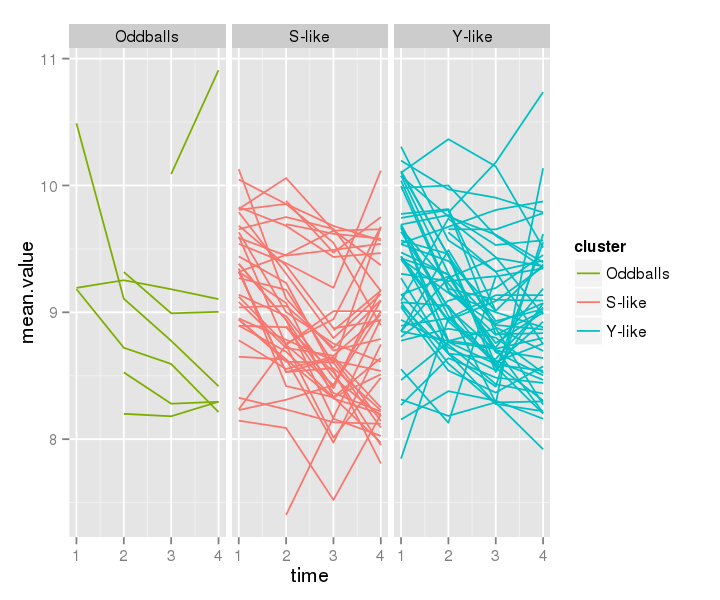

In [172]:
tmp2plot = endometabolite %>% filter(time_format=="relative", metabolite=="TRP") %>% group_by(strain, time) %>% 
    summarise(mean.value = mean(value.log2, na.rm=T), cluster = cluster[1])
p3 <- ggplot(tmp2plot, aes(x = time, y = mean.value, group = strain)) +
    geom_line(aes(color = cluster)) + facet_wrap(~ cluster) +
    scale_color_manual(values = c(gg_color_hue(4)[c(2,1,3)]))
p3

In [152]:
head(tmp2plot)

,strain,time,mean.value,cluster
1,01B,16,NA,Y-like
2,01B,17,12.67066,Y-like
3,01B,18,13.37977,Y-like
4,01B,19,13.33543,Y-like
5,01B,20,13.42717,Y-like
6,01C,16,NaN,Y-like
